# Table of Contents
1. [Data Wrangling](#Data_wrangling)<br>
    1a. [Dataframe cleaning](#cleaning)<br>
    1b. [Text preprocessing](#text)<br>

2. [EDA](#EDA)<br>

<a id='Data_wrangling'></a>

# 1. Data Wrangling
The datasets were found on webrobots.io where they crawl all Kickstarter projects once a month. For this project, the 2019-08-15 dataset was used with 56 datasets.
<br>
The data wrangling portion of this project is straightford. First we would have to eliminate features that are unrelated to campaign outcome. Also we like to create new features related to year and month to understand any temporal effect on pledge money. Then we would process the summary of campaign

In [1]:
import numpy as np
import pandas as pd
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Model
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
from nltk import ngrams

Using TensorFlow backend.


In [2]:
#define path and set up to import csv files
path = 'Dataset'
all_files = glob.glob(path +"/*.csv")

In [3]:
#create dataframes from all csv files
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col = None)
    li.append(df)
df = pd.concat(li, ignore_index = True)

In [4]:
#merge files
df = pd.concat(li, ignore_index = True)
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,103,"Funding the mixing, mastering, and promotion o...","{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-ho...",5612,US,1456593666,"{""id"":1531055178,""name"":""JC Stroebel and Henry...",USD,$,True,...,john-chuck-and-the-class-debut-ep,https://www.kickstarter.com/discover/categorie...,True,True,successful,1459964983,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",5612.0,domestic
1,318,We follow the challenges and achievements of g...,"{""id"":30,""name"":""Documentary"",""slug"":""film & v...",26237,US,1495058182,"{""id"":652875854,""name"":""Matthew Temple"",""is_re...",USD,$,True,...,girls-of-summer-big-diamond-dreams,https://www.kickstarter.com/discover/categorie...,True,True,successful,1499054401,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",26237.0,domestic
2,0,Task No.1 is inspired by the history and expre...,"{""id"":38,""name"":""Electronic Music"",""slug"":""mus...",0,GB,1357630802,"{""id"":1699678150,""name"":""Sonny Phillips"",""slug...",GBP,£,False,...,task-no1,https://www.kickstarter.com/discover/categorie...,False,False,failed,1362937678,1.614583,"{""web"":{""project"":""https://www.kickstarter.com...",0.0,international
3,22,MAJOR KEY ALERT - Future Heroes is a Denver ra...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-ho...",1575,US,1455591114,"{""id"":518056209,""name"":""Future Heroes"",""is_reg...",USD,$,True,...,future-heroes-sxsw-is-calling,https://www.kickstarter.com/discover/categorie...,True,False,successful,1457935201,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1575.0,domestic
4,17,We're traveling to Rhode Island to film Mako a...,"{""id"":30,""name"":""Documentary"",""slug"":""film & v...",3290,US,1465224753,"{""id"":632937188,""name"":""Ryan Walton"",""is_regis...",USD,$,True,...,pelagic-shark-diving-shoot,https://www.kickstarter.com/discover/categorie...,True,False,successful,1467825676,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3290.0,domestic


<a id='cleaning'></a>

## 1a. Dataframe Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207621 entries, 0 to 207620
Data columns (total 37 columns):
backers_count               207621 non-null int64
blurb                       207613 non-null object
category                    207621 non-null object
converted_pledged_amount    207621 non-null int64
country                     207621 non-null object
created_at                  207621 non-null int64
creator                     207621 non-null object
currency                    207621 non-null object
currency_symbol             207621 non-null object
currency_trailing_code      207621 non-null bool
current_currency            207621 non-null object
deadline                    207621 non-null int64
disable_communication       207621 non-null bool
friends                     444 non-null object
fx_rate                     207621 non-null float64
goal                        207621 non-null float64
id                          207621 non-null int64
is_backing                  444 

In [6]:
#drop unrelated features
df = df.drop(columns = ['backers_count', 'category', 'converted_pledged_amount','created_at', 
                             'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 
                             'current_currency', 'friends', 'id', 'is_backing', 'is_starrable', 
                             'is_starred', 'location', 'name', 'permissions', 'photo', 'pledged',
                            'profile', 'source_url', 'spotlight', 'staff_pick', 'static_usd_rate','urls',
                            'usd_pledged', 'usd_type'])

In [7]:
df.state.unique()

array(['successful', 'failed', 'canceled', 'live', 'suspended'],
      dtype=object)

In [8]:
#include only successful and unsuccesful 
df = df[df.state != 'canceled'][df.state != 'live'][df.state != 'suspend']


#convert include only US since language 
df['goal'] = df['goal']*df['fx_rate']
df = df[df['disable_communication'] == False]

C:\Users\sadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
#convert epoch to datetime
df['state_changed_at'] = df['state_changed_at'].apply(lambda x: datetime.fromtimestamp(x))
df['launched_at'] = df['launched_at'].apply(lambda x: datetime.fromtimestamp(x))
df['deadline'] = df['deadline'].apply(lambda x: datetime.fromtimestamp(x))

#create new feature for days taken to complete goals
df['days_to_state_change'] = df['state_changed_at'] - df['launched_at']
df['days_to_state_change'] = df['days_to_state_change'].dt.days

#create new feature for length of campaign
df['length_of_campaign'] = df['deadline']-df['launched_at']
df['length_of_campaign'] = df['length_of_campaign'].dt.days

In [10]:
#create launch_month and lauch_year column
df['month_launched'] = df['launched_at'].apply(lambda x: x.month)
df['year_launched'] = df['launched_at'].apply(lambda x: x.year)

#drop the used columns
df = df.drop(columns = ['launched_at', 'fx_rate', 'disable_communication', 'state_changed_at', 'deadline'])

In [11]:
#remove all null containing columns
df = df.dropna()

<a id='text'></a>

## 1b. Text Preprocessing

In [12]:
df = df.rename(columns = {'slug': 'title', 'blurb': 'summary'})
df['title'] = df['title'].apply(lambda x: ' '.join(x.split('-')))
df['summary'] = df['summary'].apply(lambda x: ' '.join(x.split('-')))

In [13]:
#detect english 
def detector(phrases):
    try:
        return detect(phrases)
    except:
        return ''

df['language'] = df.title.apply(lambda x: detector(x))

In [14]:
#remove all non-english
df = df[df.language == 'en']
df.drop(columns = ['language'])

,summary,country,goal,title,state,days_to_state_change,length_of_campaign,month_launched,year_launched
0,"Funding the mixing, mastering, and promotion o...",US,5000.00000,john chuck and the class debut ep,successful,30,30,3,2016
1,We follow the challenges and achievements of g...,US,24042.00000,girls of summer big diamond dreams,successful,26,26,6,2017
3,MAJOR KEY ALERT Future Heroes is a Denver ra...,US,500.00000,future heroes sxsw is calling,successful,19,19,2,2016
4,We're traveling to Rhode Island to film Mako a...,US,2500.00000,pelagic shark diving shoot,successful,30,30,6,2016
5,In Struggle Town the streets are protected by ...,AU,1019.09097,gorilla my dreams mime of my life,successful,28,28,10,2017
...,...,...,...,...,...,...,...,...,...
207616,"A night of music, fellowship, and a reflection...",US,500.00000,dantes capstone project who am i,successful,31,31,3,2016
207617,"The Pond of Stars creates gender neutral, affo...",US,2200.00000,the pond of stars,failed,30,30,8,2014
207618,FLUXO – The first smart design lamp where you ...,AT,55738.62600,fluxo the worlds first truly smart lamp,successful,33,33,12,2015
207619,Produced by the founder of Blackstone Magic Ba...,HK,3826.37430,next bund18 deck blackstone magic bar playing ...,successful,25,25,1,2019


In [15]:
#lowercase and tokenize the title feature
df['title'] = df.title.apply(lambda x: x.lower())
df['title'] = df.title.apply(lambda x: word_tokenize(x))

df['summary'] = df.summary.apply(lambda x: x.lower())
df['summary'] = df.summary.apply(lambda x: word_tokenize(x))

In [16]:
#remove non-alphabetical words and change n't to not, 've to have, etc, negation handling
app = {"n't": 'not', "'d": 'had', "'ve": 'have', "'re": 'are', "'ll": 'will'}
def replacing(tokens):
    output = []
    for word in tokens:
        if word in app:
            output.append(app[word])
        else:
            if word.isalpha():
                output.append(word)
    return output

df['token_title'] = df['title'].apply(lambda x: replacing(x))
df['token_summary'] = df['summary'].apply(lambda x: replacing(x))

In [17]:
#lemmatizing and stemming
ps = PorterStemmer()
wnl = WordNetLemmatizer()
def lem_stem(tokens):
    output = []
    for word in tokens:
        lem = wnl.lemmatize(word)
        ps_lem = ps.stem(lem)
        output.append(ps_lem)
    return output

df['token_title'] = df['token_title'].apply(lambda x: lem_stem(x))
df['token_summary'] = df['token_summary'].apply(lambda x: lem_stem(x))

In [18]:
#remove stopwords
stopwords = set(stopwords.words('english'))
def important_words(tokens):
    output = []
    for token in tokens:
        if token not in stopwords:
            output.append(token)
    return output


df['token_title'] = df['token_title'].apply(lambda x: important_words(x))
df['token_summary'] = df['token_summary'].apply(lambda x: important_words(x))

In [19]:
def bigrams(x):
    n = 2
    return ngrams(x, n)

df['bigram_title'] = df['token_title'].apply(lambda x: list(bigrams(x)))
df['bigram_summary'] = df['token_summary'].apply(lambda x: list(bigrams(x)))

In [20]:
df = df.drop(columns = ['language'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140786 entries, 0 to 207620
Data columns (total 13 columns):
summary                 140786 non-null object
country                 140786 non-null object
goal                    140786 non-null float64
title                   140786 non-null object
state                   140786 non-null object
days_to_state_change    140786 non-null int64
length_of_campaign      140786 non-null int64
month_launched          140786 non-null int64
year_launched           140786 non-null int64
token_title             140786 non-null object
token_summary           140786 non-null object
bigram_title            140786 non-null object
bigram_summary          140786 non-null object
dtypes: float64(1), int64(4), object(8)
memory usage: 15.0+ MB


In [21]:
df.head()

,summary,country,goal,title,state,days_to_state_change,length_of_campaign,month_launched,year_launched,token_title,token_summary,bigram_title,bigram_summary
0,"[funding, the, mixing, ,, mastering, ,, and, p...",US,5000.00000,"[john, chuck, and, the, class, debut, ep]",successful,30,30,3,2016,"[john, chuck, class, debut, ep]","[fund, mix, master, promot, debut, ep, indi, h...","[(john, chuck), (chuck, class), (class, debut)...","[(fund, mix), (mix, master), (master, promot),..."
1,"[we, follow, the, challenges, and, achievement...",US,24042.00000,"[girls, of, summer, big, diamond, dreams]",successful,26,26,6,2017,"[girl, summer, big, diamond, dream]","[follow, challeng, achiev, girl, woman, play, ...","[(girl, summer), (summer, big), (big, diamond)...","[(follow, challeng), (challeng, achiev), (achi..."
3,"[major, key, alert, future, heroes, is, a, den...",US,500.00000,"[future, heroes, sxsw, is, calling]",successful,19,19,2,2016,"[futur, hero, sxsw, call]","[major, key, alert, futur, hero, denver, rap, ...","[(futur, hero), (hero, sxsw), (sxsw, call)]","[(major, key), (key, alert), (alert, futur), (..."
4,"[we, 're, traveling, to, rhode, island, to, fi...",US,2500.00000,"[pelagic, shark, diving, shoot]",successful,30,30,6,2016,"[pelag, shark, dive, shoot]","[travel, rhode, island, film, mako, blue, shar...","[(pelag, shark), (shark, dive), (dive, shoot)]","[(travel, rhode), (rhode, island), (island, fi..."
5,"[in, struggle, town, the, streets, are, protec...",AU,1019.09097,"[gorilla, my, dreams, mime, of, my, life]",successful,28,28,10,2017,"[gorilla, dream, mime, life]","[struggl, town, street, protect, knockaround, ...","[(gorilla, dream), (dream, mime), (mime, life)]","[(struggl, town), (town, street), (street, pro..."


In [22]:
df.describe()

,goal,days_to_state_change,length_of_campaign,month_launched,year_launched
count,1.407860e+05,140786.000000,140786.000000,140786.000000,140786.000000
mean,3.629020e+04,32.229895,32.228851,6.269352,2015.895430
std,9.728037e+05,11.600616,11.599908,3.286367,2.114448
min,1.000000e-02,1.000000,1.000000,1.000000,2009.000000
25%,1.500000e+03,30.000000,30.000000,3.000000,2014.000000
50%,5.000000e+03,30.000000,30.000000,6.000000,2016.000000
75%,1.205592e+04,33.000000,33.000000,9.000000,2018.000000
max,1.000000e+08,92.000000,92.000000,12.000000,2019.000000


## Data Wrangling Summary
After concatenating the files, all repetitive and unrelated features were dropped from the combined dataset. Datasets with disabled communication was dropped since majority of the population have communications on and they are treated as outliers. The currency of goal was normalized to USD and launch month and launch years were created as new features. Days to reach goal was created as new features. All rows with null values were dropped

For text preprocessing step, we want to identify all titles that were not english since for this project, since for this project we would only want to conduct nlp for english and not multilanguage. Then we tokenized the features and removing stop words. Then punctuations and text that are not alphanumeric were removed and finally the text was stemmed and lemmatized.

<a id='EDA'></a>

# 2. EDA

Text(0.5, 1.0, 'Frequency of Success and Failed Campaigns')

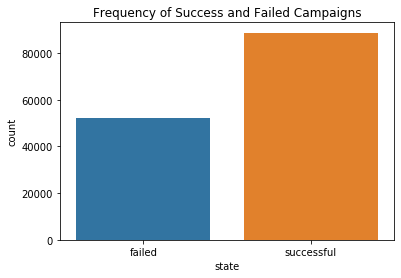

In [23]:
#create dummy count feature
df['count'] = 1

df_state = (df.groupby(['state'])
            .count()
            .reset_index())

sns.barplot(x = 'state', y = 'count', data = df_state)
plt.title('Frequency of Success and Failed Campaigns')

In [24]:
df_success = df[df.state == 'successful']
df_fail = df[df.state == 'failed']

#failed descriptive statistics
df_fail.describe()

,goal,days_to_state_change,length_of_campaign,month_launched,year_launched,count
count,5.202800e+04,52028.000000,52028.000000,52028.000000,52028.000000,52028.0
mean,7.965616e+04,34.574268,34.573614,6.367552,2015.791920,1.0
std,1.596051e+06,12.690669,12.690568,3.308523,1.740709,0.0
min,1.000000e+00,1.000000,1.000000,1.000000,2009.000000,1.0
25%,2.457628e+03,30.000000,30.000000,4.000000,2015.000000,1.0
50%,7.000000e+03,30.000000,30.000000,6.000000,2016.000000,1.0
75%,2.234208e+04,40.000000,40.000000,9.000000,2017.000000,1.0
max,1.000000e+08,92.000000,92.000000,12.000000,2019.000000,1.0


In [25]:
#successful descriptive statistics
df_success.describe()

,goal,days_to_state_change,length_of_campaign,month_launched,year_launched,count
count,8.875800e+04,88758.000000,88758.000000,88758.000000,88758.000000,88758.0
mean,1.087002e+04,30.855675,30.854402,6.211789,2015.956105,1.0
std,7.827137e+04,10.674476,10.673245,3.271958,2.303379,0.0
min,1.000000e-02,1.000000,1.000000,1.000000,2009.000000,1.0
25%,1.114773e+03,28.000000,28.000000,3.000000,2014.000000,1.0
50%,3.600000e+03,30.000000,30.000000,6.000000,2016.000000,1.0
75%,1.000000e+04,32.000000,32.000000,9.000000,2018.000000,1.0
max,1.058978e+07,91.000000,91.000000,12.000000,2019.000000,1.0


([<matplotlib.patches.Wedge at 0x18838dcb248>,
 [Text(-0.7929155430014718, 0.9007135735996661, 'US'),
  Text(0.2783646939754668, -1.16726736318118, 'GB'),
  Text(0.805618234307582, -0.8893701482235247, 'CA'),
  Text(0.9765360485130427, -0.6974075895446884, 'AU'),
  Text(1.155517026957273, -0.3236980080442649, 'Other')])

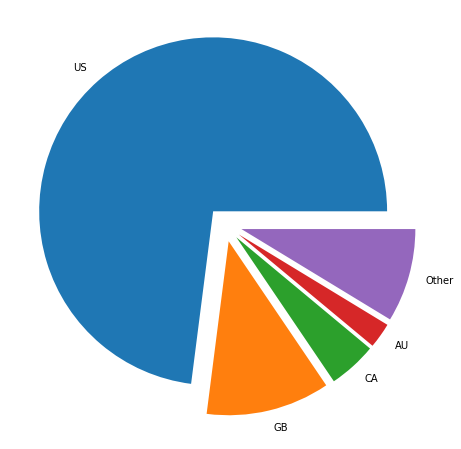

In [26]:
country_count = Counter()
for i in df.country:
    country_count[i] +=1

country = [[],[]]
for place, count in country_count.most_common(len(country_count)):
    country[0].append(place)
    country[1].append(count)
    
other_total = np.sum(country[1][4:])
country = [country[0][:4]+ ['Other'], country[1][:4] + [other_total]]
plt.figure(figsize = (8,8))
plt.pie(country[1], labels = country[0], explode = len(country[0])*[0.1])

Text(0.5, 1.0, 'Time Distribution for Length of Successful Campaigns')

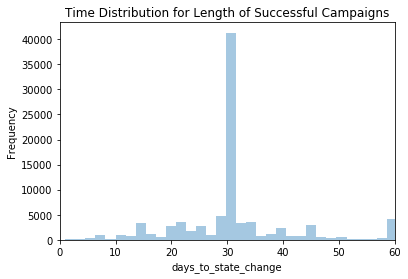

In [27]:
sns.distplot(df_success['days_to_state_change'], kde = False)
plt.ylabel('Frequency')
plt.xlim((0,60))
plt.title('Time Distribution for Length of Successful Campaigns')

Text(0.5, 1.0, 'Successfulness Frequency of by Year')

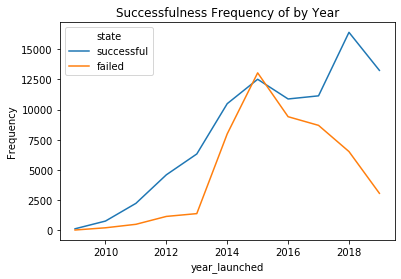

In [28]:
df_year = (df.groupby(['year_launched'])['state']
           .value_counts()
           .rename('Frequency')
           .reset_index().sort_values('year_launched'))

sns.lineplot(x = 'year_launched', y = 'Frequency', hue = 'state', data = df_year)
plt.title('Successfulness Frequency of by Year')

C:\Users\sadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


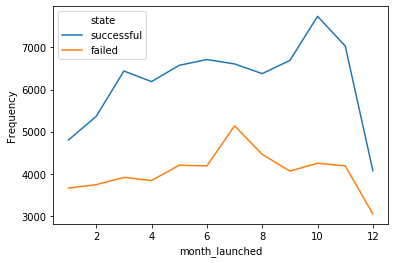

In [29]:
#adjust for incomplete year in 2009 and 2019
df_month = (df[df.year_launched > 2010][df.year_launched < 2019]
             .groupby(['month_launched'])['state']
             .value_counts()
             .rename('Frequency')
             .reset_index()
             .sort_values('month_launched'))

sns.lineplot(x = 'month_launched', y = 'Frequency', hue = 'state', data = df_month)

C:\Users\sadmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, 'Successful Campaigns by Month and Year')

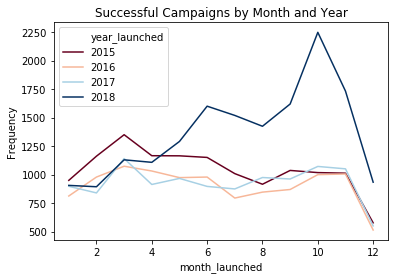

In [30]:
#most recent data
df_2015 = (df[df.year_launched > 2014][df.year_launched < 2019]
             .groupby(['month_launched', 'year_launched'])['state']
             .value_counts()
             .rename('Frequency')
             .reset_index()
             .sort_values('month_launched'))


sns.lineplot(x='month_launched', y='Frequency', hue = 'year_launched', 
             data=df_2015[df_2015.state == 'successful'], palette = 'RdBu')
plt.title('Successful Campaigns by Month and Year')

Text(0.5, 1.0, 'Failed Campaigns by Month and Year')

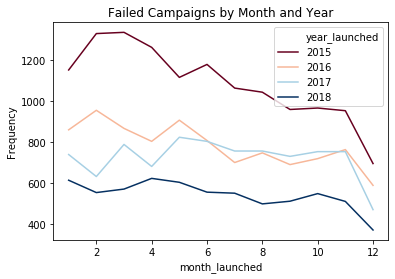

In [31]:
sns.lineplot(x='month_launched', y='Frequency', hue = 'year_launched', 
             data=df_2015[df_2015.state == 'failed'], palette = 'RdBu')
plt.title('Failed Campaigns by Month and Year')

Text(0.5, 1.0, 'Ratio of Successful/Failed Campaign by Year and Month')

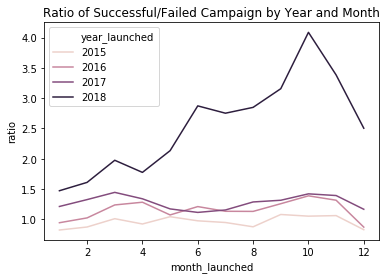

In [32]:
df_successful2015 = df_2015[df_2015.state == 'successful'].reset_index()
df_failed2015 = df_2015[df_2015.state == 'failed'].reset_index()

df_combined = df_successful2015.merge(right = df_failed2015, how = 'inner', 
                               left_on = ['month_launched', 'year_launched'], 
                               right_on = ['month_launched', 'year_launched'])

df_combined['ratio'] = df_combined.Frequency_x/df_combined.Frequency_y

sns.lineplot(x='month_launched', y = 'ratio', hue = 'year_launched', data = df_combined)
plt.title('Ratio of Successful/Failed Campaign by Year and Month')

(0, 75000)

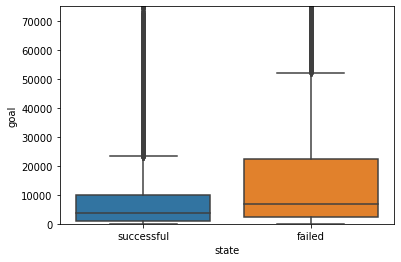

In [33]:
sns.boxplot(x = 'state', y = 'goal', data = df)
plt.ylim(0,75000)

In [34]:
failed_tile = np.percentile(df_fail['goal'], 90)
success_tile = np.percentile(df_success['goal'], 90)

print('95% of failed campaigned lies below $', failed_tile)
print('95% of successful campaigned lies below $', success_tile)

95% of failed campaigned lies below $ 60000.0
95% of successful campaigned lies below $ 21000.0


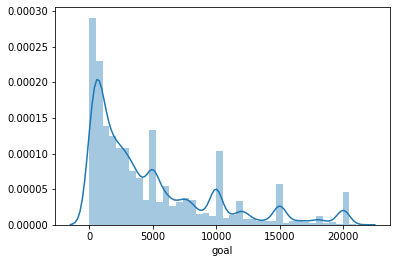

In [35]:
sns.distplot(df_success[df_success.goal < 21000]['goal'],bins = 40)

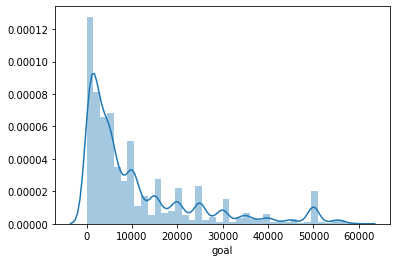

In [36]:
sns.distplot(df_fail[df_fail.goal < 60000]['goal'],bins = 40)

In [37]:
fail_count = Counter()
for title in df_fail.token_title:
    for word in title:
        fail_count[word]+=1

success_count = Counter()
for title in df_success.token_title:
    for word in title:
        success_count[word]+=1

Text(0.5, 1.0, "Most Common Words in Fail Campaign's Title")

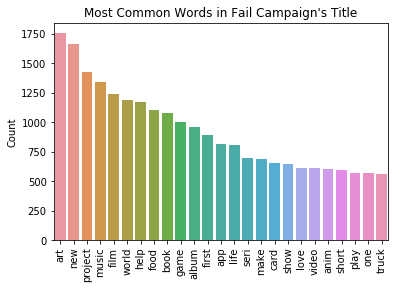

In [38]:
fail_common = [[],[]]

for day, count in fail_count.most_common(25):
    fail_common[0].append(day)
    fail_common[1].append(count)


axe = sns.barplot(x = fail_common[0], y = fail_common[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Words in Fail Campaign's Title")

Text(0.5, 1.0, "Most Common Words in Successful Campaign's Title")

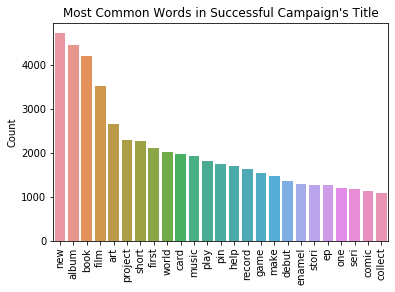

In [39]:
success_common = [[],[]]
for day, count in success_count.most_common(25):
    success_common[0].append(day)
    success_common[1].append(count)


axe = sns.barplot(x = success_common[0], y = success_common[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Words in Successful Campaign's Title")

In [40]:
def no_punc(x):
    output =[]
    for word in x:
        if word.isalnum():
            output.append(word)
    return output
df['no_pun'] = df['title'].apply(lambda x: no_punc(x))

In [41]:
success_len1 = []
for title in df[df.state == 'successful'].no_pun:
    success_len1.append(len(title))
    
fail_len1 = []
for title in df[df.state == 'failed'].no_pun:
    fail_len1.append(len(title))

Text(0.5, 1.0, 'Distribution of Number of Words in Title')

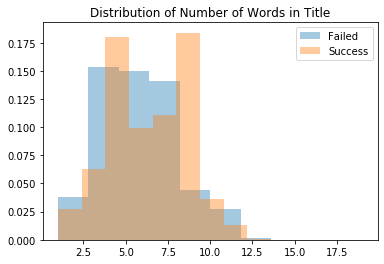

In [42]:
sns.distplot(fail_len1, bins = 10, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len1, bins = 10, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title('Distribution of Number of Words in Title')

In [43]:
avg_fail = np.mean(fail_len1)
avg_success = np.mean(success_len1)
print('Average number of important words for failed campaign is', round(avg_fail, 2))
print('Average number of important words for successful campaign is', round(avg_success,2))

Average number of important words for failed campaign is 5.73
Average number of important words for successful campaign is 6.28


In [44]:
#bootstrap
diff = avg_success - avg_fail

bootstrap = np.empty(10000)
combine = success_len1 + fail_len1
for i in range(10000):
    perm = np.random.choice(combine, size = len(combine))
    fail = np.mean(perm[:len(fail_len1)])
    success = np.mean(perm[len(fail_len1):])
    boot_diff = success - fail
    bootstrap[i] = boot_diff

p_value = np.sum(bootstrap >= diff)/len(combine)
print('p-value is', p_value)

p-value is 0.0


In [45]:
success_len2 = []
for title in df_success.token_title:
    success_len2.append(len(title))

fail_len2 = []
for title in df_fail.token_title:
    fail_len2.append(len(title))

Text(0.5, 1.0, 'Distribution of Number of "Important" Words in Title')

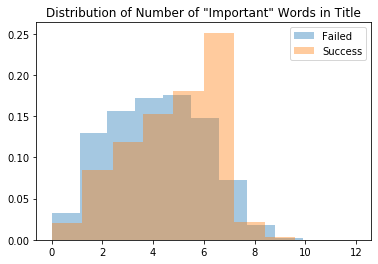

In [46]:
sns.distplot(fail_len2, bins = 10, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len2, bins = 10, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title('Distribution of Number of "Important" Words in Title')

In [47]:
avg_fail = np.mean(fail_len2)
avg_success = np.mean(success_len2)
print('Average number of important words for failed campaign is', round(avg_fail, 2))
print('Average number of important words for successful campaign is', round(avg_success,2))

Average number of important words for failed campaign is 4.28
Average number of important words for successful campaign is 4.63


In [48]:
#bootstrap
diff = avg_success - avg_fail

bootstrap = np.empty(10000)
combine = success_len2 + fail_len2
for i in range(10000):
    perm = np.random.choice(combine, size = len(combine))
    fail = np.mean(perm[:len(fail_len2)])
    success = np.mean(perm[len(fail_len2):])
    boot_diff = success - fail
    bootstrap[i] = boot_diff

p_value = np.sum(bootstrap >= diff)/len(combine)
print('p-value is', p_value)

p-value is 0.0


In [49]:
fail_bigram_count = Counter()
for title in df_fail.bigram_title:
    for bigram in list(title):
        fail_bigram_count[bigram]+=1

success_bigram_count = Counter()
for summary in df_success.bigram_title:
    for bigram in summary:
        success_bigram_count[bigram]+=1

Text(0.5, 1.0, "Most Common Bigram in Fail Campaign's Title")

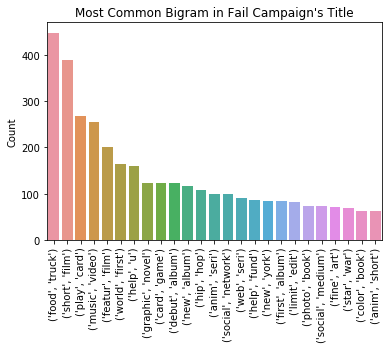

In [50]:
fail_bigram = [[],[]]

for words, count in fail_bigram_count.most_common(25):
    fail_bigram[0].append(str(words))
    fail_bigram[1].append(count)


axe = sns.barplot(x = fail_bigram[0], y = fail_bigram[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Bigram in Fail Campaign's Title")

Text(0.5, 1.0, "Most Common Bigram in Successful Campaign's Title")

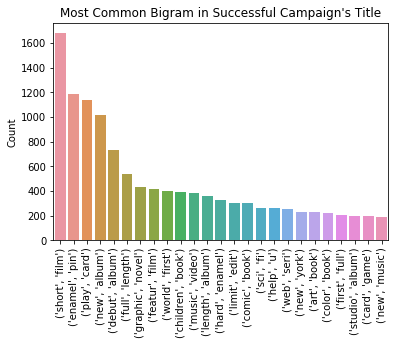

In [51]:
success_bigram = [[],[]]

for words, count in success_bigram_count.most_common(25):
    success_bigram[0].append(str(words))
    success_bigram[1].append(count)


axe = sns.barplot(x = success_bigram[0], y = success_bigram[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Bigram in Successful Campaign's Title")

In [52]:
fail_count = Counter()
for summary in df_fail.token_summary:
    for word in summary:
        fail_count[word]+=1

success_count = Counter()
for summary in df_success.token_summary:
    for word in summary:
        success_count[word]+=1

Text(0.5, 1.0, "Most Common Words in Fail Campaign's Summary")

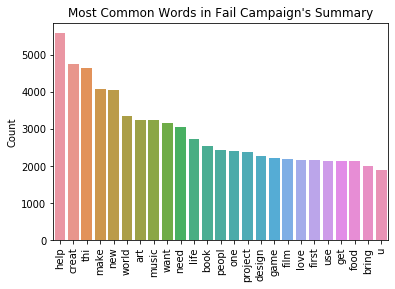

In [53]:
fail_common = [[],[]]

for day, count in fail_count.most_common(25):
    fail_common[0].append(day)
    fail_common[1].append(count)


axe = sns.barplot(x = fail_common[0], y = fail_common[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Words in Fail Campaign's Summary")

Text(0.5, 1.0, "Most Common Words in Successful Campaign's Summary")

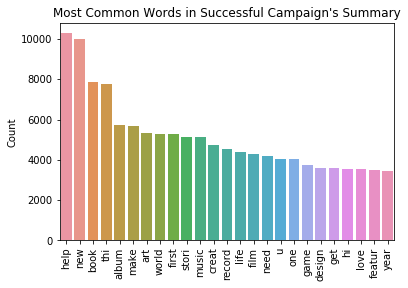

In [54]:
success_common = [[],[]]
for day, count in success_count.most_common(25):
    success_common[0].append(day)
    success_common[1].append(count)


axe = sns.barplot(x = success_common[0], y = success_common[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Words in Successful Campaign's Summary")

In [55]:
def no_punc(x):
    output =[]
    for word in x:
        if word.isalnum():
            output.append(word)
    return output
df['no_pun_sum'] = df['summary'].apply(lambda x: no_punc(x))

In [56]:
success_len1 = []
for summary in df[df.state == 'successful'].no_pun_sum:
    success_len1.append(len(summary))
    
fail_len1 = []
for summary in df[df.state == 'failed'].no_pun_sum:
    fail_len1.append(len(summary))

Text(0.5, 1.0, 'Distribution of Number of Words in Summary')

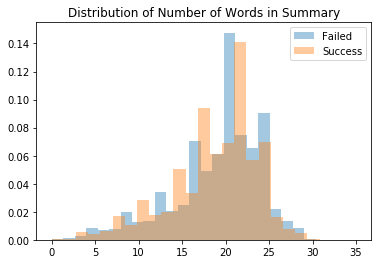

In [57]:
sns.distplot(fail_len1,bins = 25, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len1, bins = 25, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title('Distribution of Number of Words in Summary')

In [58]:
avg_fail = np.mean(fail_len1)
avg_success = np.mean(success_len1)
print('Average number of important words for failed campaign is', round(avg_fail, 2))
print('Average number of important words for successful campaign is', round(avg_success,2))

Average number of important words for failed campaign is 19.13
Average number of important words for successful campaign is 18.67


In [59]:
#bootstrap
diff = avg_success - avg_fail

bootstrap = np.empty(10000)
combine = success_len1 + fail_len1
for i in range(10000):
    perm = np.random.choice(combine, size = len(combine))
    fail = np.mean(perm[:len(fail_len1)])
    success = np.mean(perm[len(fail_len1):])
    boot_diff = success - fail
    bootstrap[i] = boot_diff

p_value = np.sum(bootstrap >= diff)/len(combine)
print('p-value is', p_value)

p-value is 0.07102978989388149


In [60]:
success_len2 = []
for summary in df_success.token_summary:
    success_len2.append(len(summary))

fail_len2 = []
for summary in df_fail.token_summary:
    fail_len2.append(len(summary))

Text(0.5, 1.0, 'Distribution of Number of "Important" Words in Summary')

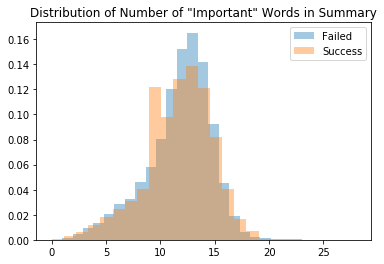

In [61]:
sns.distplot(fail_len2, bins = 25, kde = False, norm_hist = True, label = 'Failed')
sns.distplot(success_len2, bins = 25, kde = False, norm_hist = True, label = 'Success')
plt.legend(loc = 'upper right')
plt.title('Distribution of Number of "Important" Words in Summary')

In [62]:
avg_fail = np.mean(fail_len2)
avg_success = np.mean(success_len2)
print('Average number of important words for failed campaign is', round(avg_fail, 2))
print('Average number of important words for successful campaign is', round(avg_success,2))

Average number of important words for failed campaign is 11.72
Average number of important words for successful campaign is 11.71


In [63]:
fail_bigram_count = Counter()
for summary in df_fail.bigram_summary:
    for bigram in list(summary):
        fail_bigram_count[bigram]+=1

success_bigram_count = Counter()
for summary in df_success.bigram_summary:
    for bigram in summary:
        success_bigram_count[bigram]+=1

Text(0.5, 1.0, "Most Common Bigram in Fail Campaign's Summary")

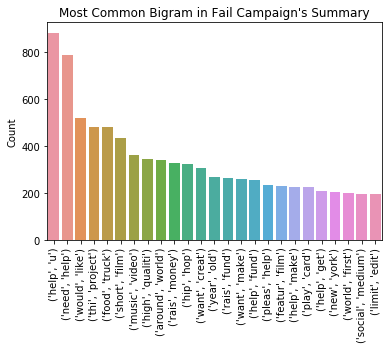

In [64]:
fail_bigram = [[],[]]

for words, count in fail_bigram_count.most_common(25):
    fail_bigram[0].append(str(words))
    fail_bigram[1].append(count)


axe = sns.barplot(x = fail_bigram[0], y = fail_bigram[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Bigram in Fail Campaign's Summary")

Text(0.5, 1.0, "Most Common Bigram in Successful Campaign's Summary")

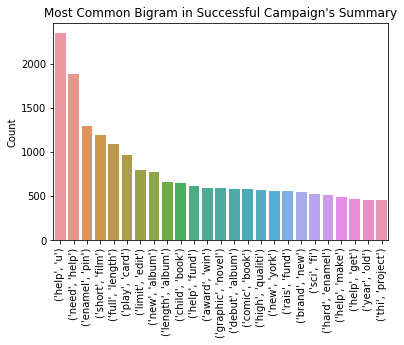

In [65]:
success_bigram = [[],[]]

for words, count in success_bigram_count.most_common(25):
    success_bigram[0].append(str(words))
    success_bigram[1].append(count)


axe = sns.barplot(x = success_bigram[0], y = success_bigram[1])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title("Most Common Bigram in Successful Campaign's Summary")